In [ ]:
!pip install kagglehub --upgrade

In [8]:
import kagglehub

# Define a custom path
# custom_path = "/content/chest_xray_pneumonia"

# Download dataset to the specified location
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Dataset downloaded to:", path)


100%|██████████| 2.29G/2.29G [00:15<00:00, 161MB/s]

Extracting files...


Dataset downloaded to: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2


In [9]:
import shutil

# Define source and destination paths
src = "/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2"
dst = "/content/"

# Move the folder
shutil.move(src, dst)

print("Dataset moved to:", dst)


Dataset moved to: /content/chest_xray_pneumonia


In [10]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D


In [11]:
# Load Data
data_dir = "chest_xray"
batch_size = 32
img_size = (224, 224)

In [12]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_gen = datagen.flow_from_directory(data_dir + '/train', target_size=img_size, batch_size=batch_size, class_mode='binary')
val_gen = datagen.flow_from_directory(data_dir + '/val', target_size=img_size, batch_size=batch_size, class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [13]:
# Build Model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
out = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=out)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [14]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [15]:
history = model.fit(train_gen, validation_data=val_gen, epochs=10)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 73s 364ms/step - accuracy: 0.7593 - loss: 0.5436 - val_accuracy: 0.6250 - val_loss: 0.6266
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 49s 303ms/step - accuracy: 0.7988 - loss: 0.4205 - val_accuracy: 0.5625 - val_loss: 1.0099
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 50s 307ms/step - accuracy: 0.8315 - loss: 0.3652 - val_accuracy: 0.5625 - val_loss: 1.1865
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 49s 302ms/step - accuracy: 0.8306 - loss: 0.3552 - val_accuracy: 0.6250 - val_loss: 1.0051
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 83s 307ms/step - accuracy: 0.8421 - loss: 0.3400 - val_accuracy: 0.5625 - val_loss: 1.0745
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 49s 300ms/step - accuracy: 0.8579 - loss: 0.3114 - val_accuracy: 0.5625 - val_loss: 1.1983
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 49s 299ms/step - accuracy: 0.8613 - loss: 0.3059 - val_accuracy: 0.6250 - val_loss: 1.0758
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 49s 298ms/step - accuracy: 0.8772 - loss: 0

In [27]:
def grad_cam(model, img_array, layer_name='conv5_block3_out'):
    grad_model = Model(inputs=model.input, outputs=[model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        inputs = tf.convert_to_tensor(img_array, dtype=tf.float32)
        tape.watch(inputs)
        conv_outputs, predictions = grad_model(inputs)
        loss = predictions[:, 0]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0].numpy()
    pooled_grads = pooled_grads.numpy()

    for i in range(conv_outputs.shape[-1]):
        conv_outputs[..., i] *= pooled_grads[i]

    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) + 1e-8
    return heatmap

In [28]:
img_path = "/content/chest_xray/test/NORMAL/IM-0001-0001.jpeg"
img = cv2.imread(img_path)
img = cv2.resize(img, img_size)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_array = np.expand_dims(img, axis=0) / 255.0

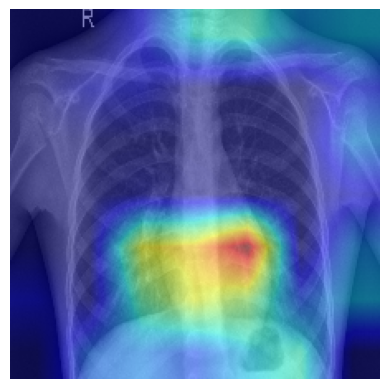

In [29]:
heatmap = grad_cam(model, img_array)
plt.imshow(img)
plt.imshow(cv2.resize(heatmap, img_size), alpha=0.5, cmap='jet')
plt.axis('off')
plt.show()

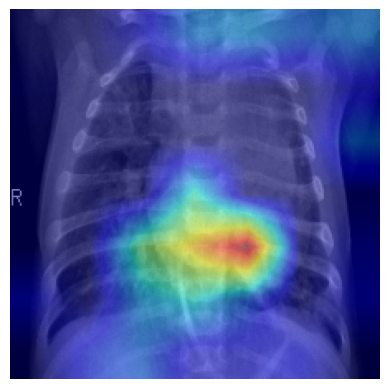

In [30]:
img_path = "/content/chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg"
img = cv2.imread(img_path)
img = cv2.resize(img, img_size)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_array = np.expand_dims(img, axis=0) / 255.0

heatmap = grad_cam(model, img_array)
plt.imshow(img)
plt.imshow(cv2.resize(heatmap, img_size), alpha=0.5, cmap='jet')
plt.axis('off')
plt.show()